In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
import seaborn as sns
import nltk
# nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
tweets=pd.read_csv('datasets/Tweet.csv')
company_tweet=pd.read_csv('datasets/Company_Tweet.csv')
tweets=tweets.merge(company_tweet,how='left',on='tweet_id')
tweets['date'] = pd.to_datetime(tweets['post_date'], unit='s').dt.date
tweets.date=pd.to_datetime( tweets.date,errors='coerce')
tweets['time'] = pd.to_datetime(tweets['post_date'], unit='s').dt.time

In [3]:
tweets['ticker_symbol'].value_counts()

ticker_symbol
AAPL     1425013
TSLA     1096868
AMZN      718715
GOOG      392569
MSFT      375711
GOOGL     327569
Name: count, dtype: int64

In [4]:
tweets

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num,ticker_symbol,date,time
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01,00:00:57
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01,00:01:36
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01,00:01:50
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01,00:06:47
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01,00:10:05
...,...,...,...,...,...,...,...,...,...,...
4336440,1212159838882533376,ShortingIsFun,1577836401,In 2020 I may start Tweeting out positive news...,0,0,1,TSLA,2019-12-31,23:53:21
4336441,1212160015332728833,Commuternyc,1577836443,Patiently Waiting for the no twitter sitter tw...,0,0,5,TSLA,2019-12-31,23:54:03
4336442,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1,AAPL,2019-12-31,23:55:37
4336443,1212160410692046849,MoriaCrypto,1577836537,I don't discriminate. I own both $aapl and $ms...,1,0,1,MSFT,2019-12-31,23:55:37


# For Apple Data

In [5]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(tweets,ticker='AAPL',start='2015-01-01',end='2018-12-31'):
    df=tweets.loc[((tweets.ticker_symbol==ticker)&(tweets.date>=start)&(tweets.date<=end))]
    df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
    df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
    df=df.loc[:,["date","score","label","tweet_id","body", "ticker_symbol"]]
    return df

print('apple misses earnings, analyst suggest downgrade , sell now ')
sia.polarity_scores('apple misses earnings, analyst suggest downgrade , sell now ')

apple misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}

In [6]:
positive_words='high profit Growth Potential Opportunity Bullish Strong Valuable Success Promising Profitable Win Winner Outstanding Record Earnings Breakthrough buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding'
negative_words='slowdown rough TechCrash falls sell-off lower crash losing Tough inflation fears resistance squeeze cover seller Risk Loss Decline Bearish Weak Declining Uncertain Troubling Downturn Struggle Unstable Volatile Slump Disaster Plunge sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss terrible dont donot not'
dictOfpos = { i : 4 for i in positive_words.split(" ") }
dictOfneg = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon = {**dictOfpos, **dictOfneg}
sia.lexicon.update(Financial_Lexicon)
print('apple misses earnings, analyst suggest downgrade , sell now ')
sia.polarity_scores('apple misses earnings, analyst suggest downgrade , sell now ')

apple misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.535, 'neu': 0.465, 'pos': 0.0, 'compound': -0.7845}

In [7]:
start='2015-01-01'
end='2018-12-31'
ticker='AAPL'
tw_apple=get_sentiment(tweets,ticker,start,end)
tw_apple.head()

/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/233790143.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('score')]=df.loc[:,'body'].apply(lambda x: sia.polarity_scores(x)['compound'])
/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/233790143.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,('label')]=pd.cut(np.array(df.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])


,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL
1,2015-01-01,-0.8271,bad,550441672312512512,Insanity of today weirdo massive selling. $aap...,AAPL
4,2015-01-01,0.0000,neutral,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL
6,2015-01-01,0.0000,neutral,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL
8,2015-01-01,0.0000,neutral,550443809700851716,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL


/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/4101320618.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts = tw_apple.groupby(['date', 'label']).size().unstack(fill_value=0)


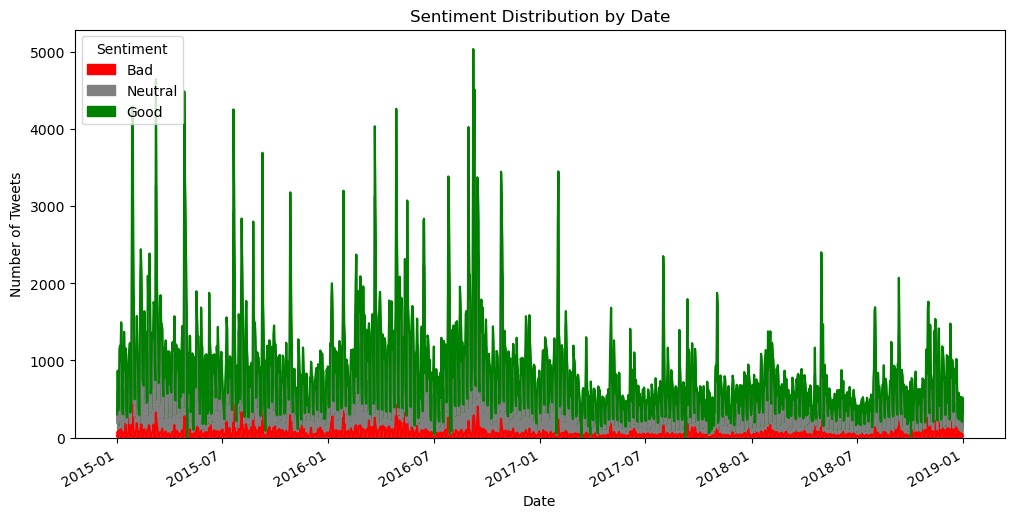

In [8]:
tw_apple['date'] = pd.to_datetime(tw_apple['date'])
sentiment_counts = tw_apple.groupby(['date', 'label']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'good': 'green', 'neutral': 'grey', 'bad': 'red'}
area = sentiment_counts.plot.area(stacked=True, ax=ax, color=[colors[c] for c in sentiment_counts.columns])
handles = [mpatches.Patch(color=colors[label], label=label.capitalize()) for label in sentiment_counts.columns]
ax.legend(handles=handles, title='Sentiment', loc="upper left")
plt.title('Sentiment Distribution by Date')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [9]:
tw_apple['date'] = pd.to_datetime(tw_apple['date'])
daily_sentiment_apple = tw_apple.groupby(tw_apple['date'].dt.date)['score'].mean()
daily_sentiment_df_apple = pd.DataFrame({'Date': daily_sentiment_apple.index, 'Average Score': daily_sentiment_apple.values})
daily_sentiment_df_apple.head()

,Date,Average Score
0,2015-01-01,0.132334
1,2015-01-02,0.072022
2,2015-01-03,0.263895
3,2015-01-04,0.218598
4,2015-01-05,0.120478


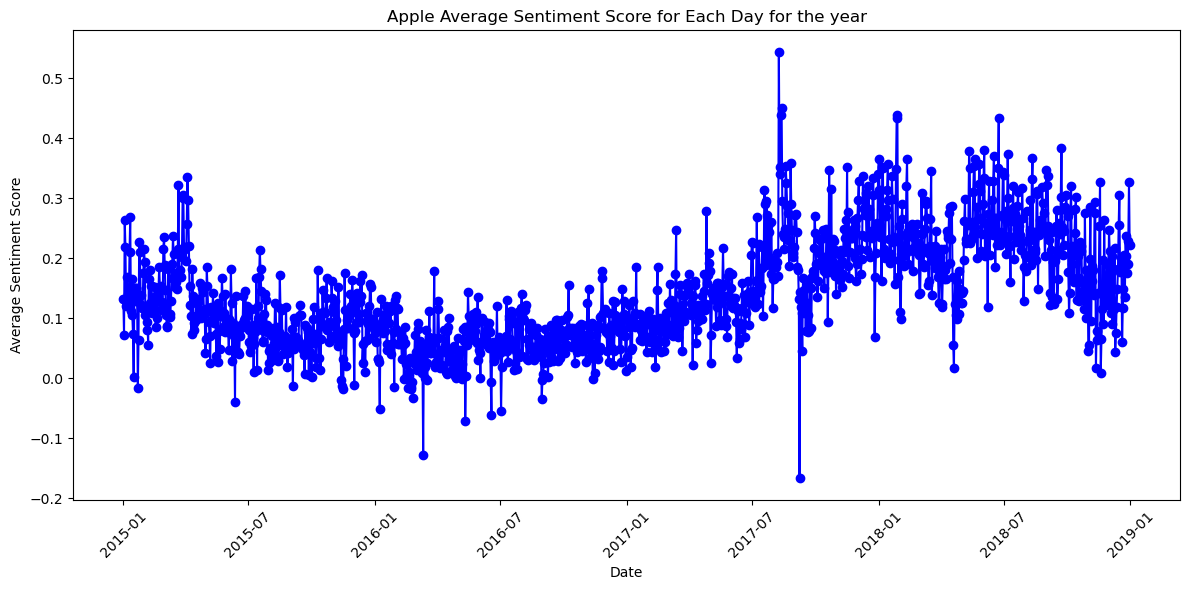

In [200]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_sentiment_apple.index, daily_sentiment_apple, marker='o', linestyle='-', color='b')
ax.set_xlabel('Date')
ax.set_ylabel('Average Sentiment Score')
plt.title('Apple Average Sentiment Score for Each Day for the year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

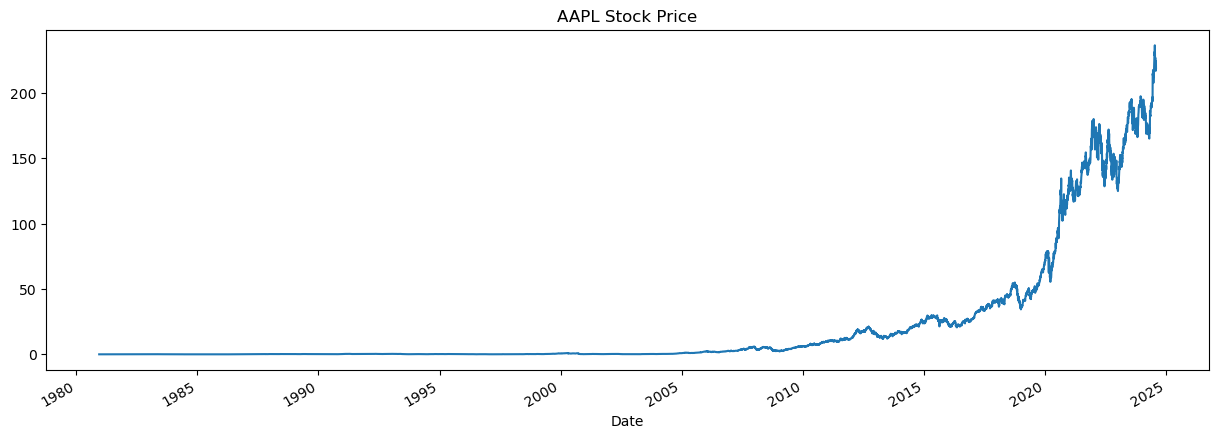

In [11]:
import yfinance as yf
aapl = yf.Ticker("AAPL")
hist = aapl.history(period="max")
hist["Open"].plot(figsize=(15, 5), title="AAPL Stock Price")
plt.show()

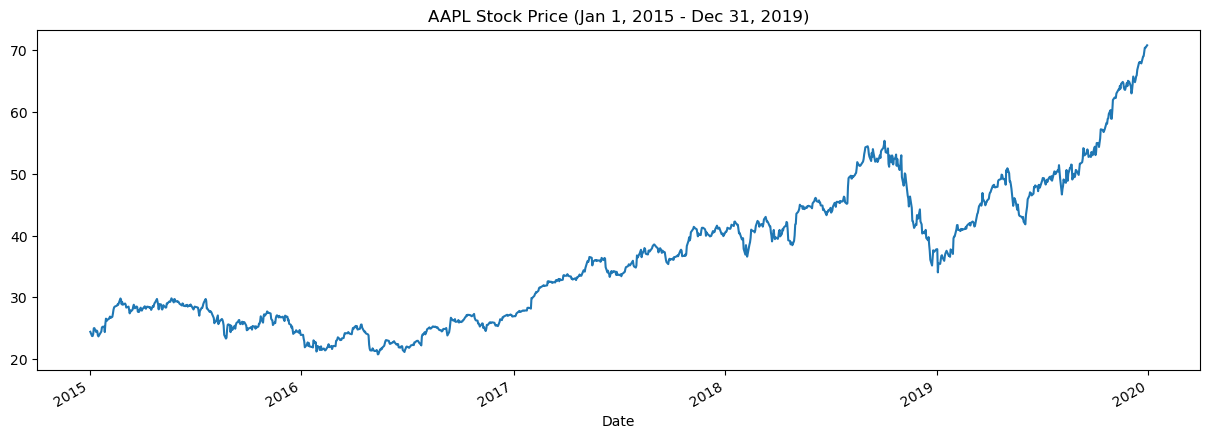

In [12]:
stock_symbol = "AAPL"
start_date = "2015-01-01"
end_date = "2019-12-31"
stock = yf.Ticker(stock_symbol)
hist = stock.history(period="1d", start=start_date, end=end_date)
hist["Close"].plot(figsize=(15, 5), title=f"{stock_symbol} Stock Price (Jan 1, 2015 - Dec 31, 2019)")
plt.show()

In [13]:
start_date = '2015-01-01'
end_date = '2019-12-31'
date_range = pd.date_range(start=start_date, end=end_date)
full_hist_apple = pd.DataFrame(index=date_range)
full_hist_apple.index = full_hist_apple.index.tz_localize(hist.index.tz)
full_hist_apple = full_hist_apple.combine_first(hist)
full_hist_apple = full_hist_apple.fillna(0)
full_hist_apple.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
2015-01-01 00:00:00-05:00,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0
2015-01-02 00:00:00-05:00,24.402172,0.0,24.873119,23.96024,24.861958,0.0,212818400.0
2015-01-03 00:00:00-05:00,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0
2015-01-04 00:00:00-05:00,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0
2015-01-05 00:00:00-05:00,23.714725,0.0,24.250400,23.52724,24.170048,0.0,257142000.0


In [14]:
tw_apple

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",AAPL
1,2015-01-01,-0.8271,bad,550441672312512512,Insanity of today weirdo massive selling. $aap...,AAPL
4,2015-01-01,0.0000,neutral,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL
6,2015-01-01,0.0000,neutral,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL
8,2015-01-01,0.0000,neutral,550443809700851716,Swing Trading: Up To 8.91% Return In 14 Days h...,AAPL
...,...,...,...,...,...,...
3431111,2018-12-31,0.8519,good,1079883982794379264,Join @RobinhoodApp and we'll both get a stock ...,AAPL
3431113,2018-12-31,0.0000,neutral,1079884177770655744,"Comment: It's 2019, Instagram should make an i...",AAPL
3431114,2018-12-31,-0.9001,bad,1079884283433574400,$AAPL Gap Data: Notice lower wick. 1st 15min b...,AAPL
3431126,2018-12-31,-0.6917,bad,1079887341366530049,+50 Points Today! Come Start the New Year out ...,AAPL


In [15]:
tw_apple.to_csv('sentimental_dataset_apple.csv', index=False)

# For Amazon Data

In [16]:
sia_amazon = SentimentIntensityAnalyzer()

def get_sentiment1(tweets,ticker='AMZN',start='2015-01-01',end='2019-12-31'):
    df1=tweets.loc[((tweets.ticker_symbol==ticker)&(tweets.date>=start)&(tweets.date<=end))]
    df1.loc[:,('score')]=df1.loc[:,'body'].apply(lambda x: sia_amazon.polarity_scores(x)['compound'])
    df1.loc[:,('label')]=pd.cut(np.array(df1.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
    df1=df1.loc[:,["date","score","label","tweet_id","body", "ticker_symbol"]]
    return df1

print('amazon misses earnings, analyst suggest downgrade , sell now ')
sia_amazon.polarity_scores('amazon misses earnings, analyst suggest downgrade , sell now ')

amazon misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.198, 'neu': 0.625, 'pos': 0.177, 'compound': -0.0516}

In [17]:
# positive_words='high profit Growth Potential Opportunity Bullish Strong Valuable Success Promising Profitable Win Winner Outstanding Record Earnings Breakthrough buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding'
# negative_words='slowdown rough TechCrash falls sell-off lower crash losing Tough inflation fears resistance squeeze cover seller Risk Loss Decline Bearish Weak Declining Uncertain Troubling Downturn Struggle Unstable Volatile Slump Disaster Plunge sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss terrible dont donot not'
# dictOfpos1 = { i : 4 for i in positive_words.split(" ") }
# dictOfneg1 = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon1 = {**dictOfpos, **dictOfneg}
sia_amazon.lexicon.update(Financial_Lexicon1)
print('amazon misses earnings, analyst suggest downgrade , sell now ')
sia_amazon.polarity_scores('amazon misses earnings, analyst suggest downgrade , sell now ')

amazon misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.507, 'neu': 0.368, 'pos': 0.125, 'compound': -0.7351}

In [18]:
start='2015-01-01'
end='2019-12-31'
ticker='AMZN'
tw_amazon=get_sentiment1(tweets,ticker,start,end)
tw_amazon.head()

/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/2338347703.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,('score')]=df1.loc[:,'body'].apply(lambda x: sia_amazon.polarity_scores(x)['compound'])
/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/2338347703.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,('label')]=pd.cut(np.array(df1.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])


,date,score,label,tweet_id,body,ticker_symbol
2,2015-01-01,0.0000,neutral,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,AMZN
27,2015-01-01,0.2023,neutral,550447850857828352,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,AMZN
37,2015-01-01,0.0000,neutral,550453172096217088,RT @SeekingAlpha: A Look At BlackBerry's Deals...,AMZN
38,2015-01-01,-0.7506,bad,550453624258965505,Jeff Bezos lost $7.4 billion in Amazon's worst...,AMZN
39,2015-01-01,-0.7506,bad,550453897714995200,Jeff Bezos lost $7.4 billion in #Amazon worst ...,AMZN


/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/864827296.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts_amazon = tw_amazon.groupby(['date', 'label']).size().unstack(fill_value=0)


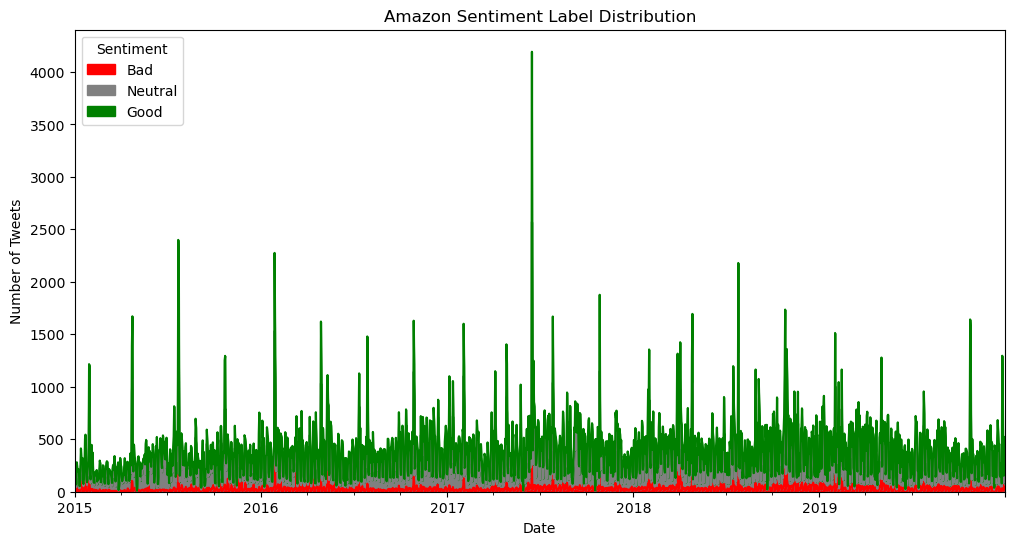

In [264]:
tw_amazon['date'] = pd.to_datetime(tw_amazon['date'])
sentiment_counts_amazon = tw_amazon.groupby(['date', 'label']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'good': 'green', 'neutral': 'grey', 'bad': 'red'}
area = sentiment_counts_amazon.plot.area(stacked=True, ax=ax, color=[colors[c] for c in sentiment_counts_amazon.columns])
handles = [mpatches.Patch(color=colors[label], label=label.capitalize()) for label in sentiment_counts_amazon.columns]
ax.legend(handles=handles, title='Sentiment', loc="upper left")
plt.title('Amazon Sentiment Label Distribution')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [265]:
tw_amazon['date'] = pd.to_datetime(tw_amazon['date'])
daily_sentiment_amazon = tw_amazon.groupby(tw_amazon['date'].dt.date)['score'].mean()
daily_sentiment_df_amazon = pd.DataFrame({'Date': daily_sentiment_amazon.index, 'Average Score': daily_sentiment_amazon.values})
daily_sentiment_df_amazon.head()

,Date,Average Score
0,2015-01-01,-0.154491
1,2015-01-02,0.100628
2,2015-01-03,0.150646
3,2015-01-04,0.101540
4,2015-01-05,0.038268


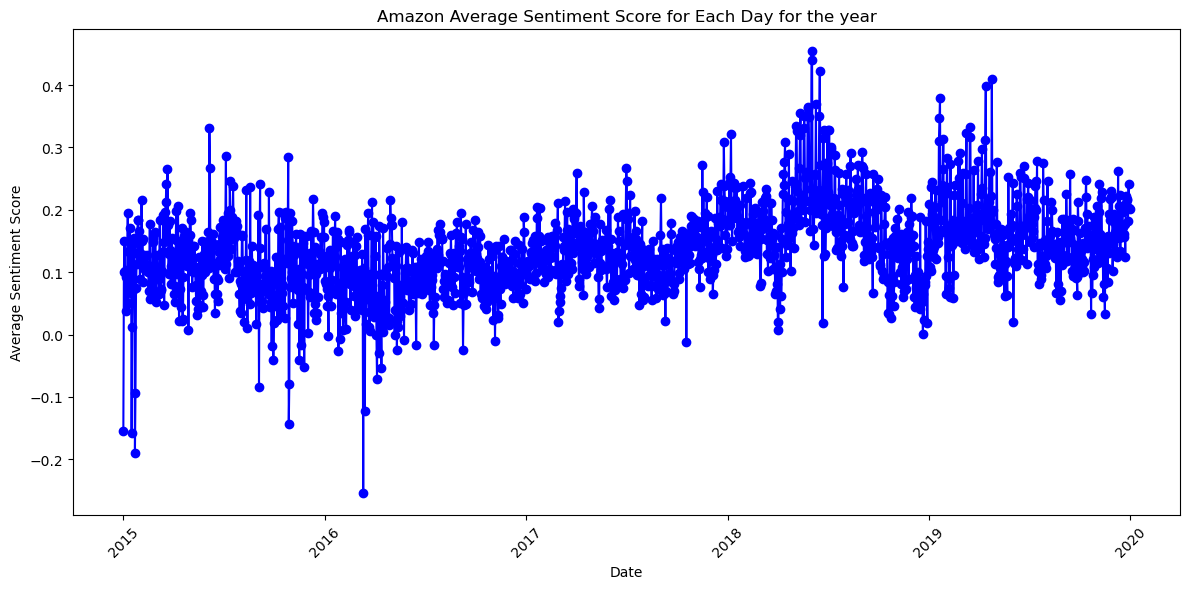

In [266]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_sentiment_amazon.index, daily_sentiment_amazon, marker='o', linestyle='-', color='b')
ax.set_xlabel('Date')
ax.set_ylabel('Average Sentiment Score')
plt.title('Amazon Average Sentiment Score for Each Day for the year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

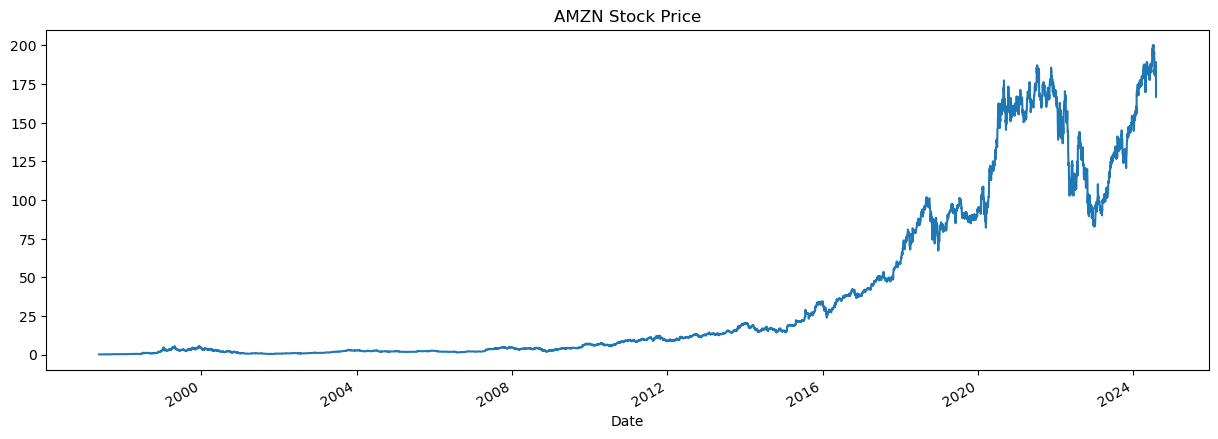

In [22]:
import yfinance as yf
amzn = yf.Ticker("AMZN")
hist = amzn.history(period="max")
hist["Open"].plot(figsize=(15, 5), title="AMZN Stock Price")
plt.show()

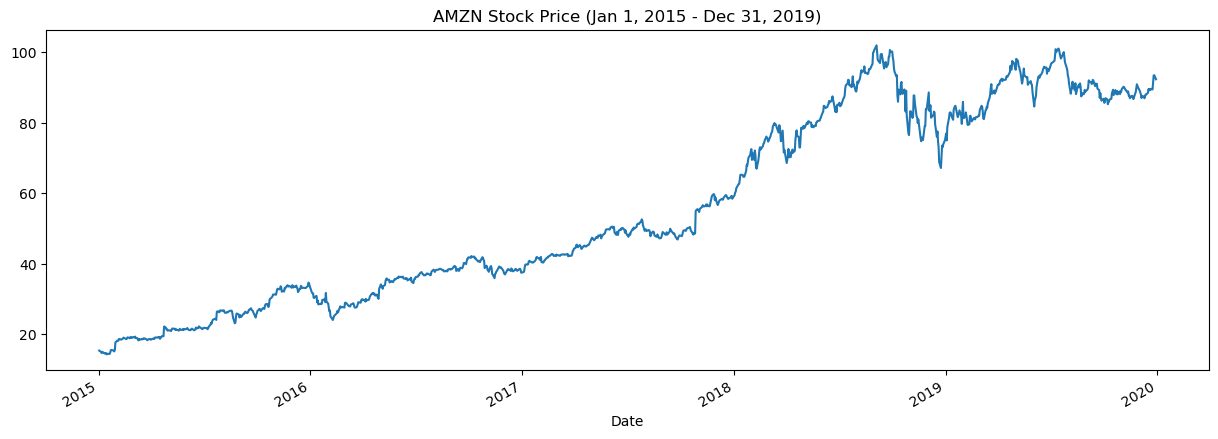

In [23]:
stock_symbol = "AMZN"
start_date = "2015-01-01"
end_date = "2019-12-31"
stock_amzn = yf.Ticker(stock_symbol)
hist = stock_amzn.history(period="1d", start=start_date, end=end_date)
hist["Close"].plot(figsize=(15, 5), title=f"{stock_symbol} Stock Price (Jan 1, 2015 - Dec 31, 2019)")
plt.show()

In [24]:
start_date = '2015-01-01'
end_date = '2019-12-31'
date_range_amazon = pd.date_range(start=start_date, end=end_date)
full_hist_amazon = pd.DataFrame(index=date_range_amazon)
full_hist_amazon.index = full_hist_amazon.index.tz_localize(hist.index.tz)
full_hist_amazon = full_hist_amazon.combine_first(hist)
full_hist_amazon = full_hist_amazon.fillna(0)
full_hist_amazon.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
2015-01-01 00:00:00-05:00,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0
2015-01-02 00:00:00-05:00,15.4260,0.0,15.7375,15.3480,15.6290,0.0,55664000.0
2015-01-03 00:00:00-05:00,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0
2015-01-04 00:00:00-05:00,0.0000,0.0,0.0000,0.0000,0.0000,0.0,0.0
2015-01-05 00:00:00-05:00,15.1095,0.0,15.4190,15.0425,15.3505,0.0,55484000.0


In [25]:
tw_amazon.to_csv('sentimental_dataset_amazon.csv', index=False)

# For Google Data

In [26]:
sia_google = SentimentIntensityAnalyzer()

def get_sentiment1(tweets,ticker='GOOG',start='2015-01-01',end='2019-12-31'):
    df1=tweets.loc[((tweets.ticker_symbol==ticker)&(tweets.date>=start)&(tweets.date<=end))]
    df1.loc[:,('score')]=df1.loc[:,'body'].apply(lambda x: sia_google.polarity_scores(x)['compound'])
    df1.loc[:,('label')]=pd.cut(np.array(df1.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])
    df1=df1.loc[:,["date","score","label","tweet_id","body", "ticker_symbol"]]
    return df1

print('google misses earnings, analyst suggest downgrade , sell now ')
sia_google.polarity_scores('google misses earnings, analyst suggest downgrade , sell now ')

google misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.213, 'neu': 0.787, 'pos': 0.0, 'compound': -0.2263}

In [27]:
# positive_words='high profit Growth Potential Opportunity Bullish Strong Valuable Success Promising Profitable Win Winner Outstanding Record Earnings Breakthrough buy bull long support undervalued underpriced cheap upward rising trend moon rocket hold breakout call beat support buying holding'
# negative_words='slowdown rough TechCrash falls sell-off lower crash losing Tough inflation fears resistance squeeze cover seller Risk Loss Decline Bearish Weak Declining Uncertain Troubling Downturn Struggle Unstable Volatile Slump Disaster Plunge sell bear bubble bearish short overvalued overbought overpriced expensive downward falling sold sell low put miss terrible dont donot not'
# dictOfpos1 = { i : 4 for i in positive_words.split(" ") }
# dictOfneg1 = { i : -4 for i in negative_words.split(" ")  }
Financial_Lexicon1 = {**dictOfpos, **dictOfneg}
sia_google.lexicon.update(Financial_Lexicon1)
print('google misses earnings, analyst suggest downgrade , sell now ')
sia_google.polarity_scores('google misses earnings, analyst suggest downgrade , sell now ')

google misses earnings, analyst suggest downgrade , sell now 


{'neg': 0.535, 'neu': 0.465, 'pos': 0.0, 'compound': -0.7845}

In [28]:
start='2015-01-01'
end='2019-12-31'
ticker='GOOG'
tw_google=get_sentiment1(tweets,ticker,start,end)
tw_google.head()

/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/823908990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,('score')]=df1.loc[:,'body'].apply(lambda x: sia_google.polarity_scores(x)['compound'])
/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/823908990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:,('label')]=pd.cut(np.array(df1.loc[:,'score']),bins=[-1, -0.66, 0.32, 1],right=True ,labels=["bad", "neutral", "good"])


,date,score,label,tweet_id,body,ticker_symbol
26,2015-01-01,0.2023,neutral,550447850857828352,Top 10 searched #stocks of #2014 $AAPL $FB $BA...,GOOG
32,2015-01-01,-0.6486,neutral,550449439631233026,#GOOGLE 'C' : Chinese paper blames Google over...,GOOG
36,2015-01-01,0.6249,good,550453087731982336,"""http://iphone.appleinsider.com/articles/14/12...",GOOG
58,2015-01-01,0.5423,good,550461555423584257,Prediction: $TWTR $GRPN $YELP are acquired as ...,GOOG
65,2015-01-01,-0.4767,neutral,550463776437174272,"$goog is roughly fairly valued, not a buy or s...",GOOG


/var/folders/bh/phg5j6rx557fc31zr9pgztnr0000gn/T/ipykernel_2531/2358863216.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_counts_google = tw_google.groupby(['date', 'label']).size().unstack(fill_value=0)


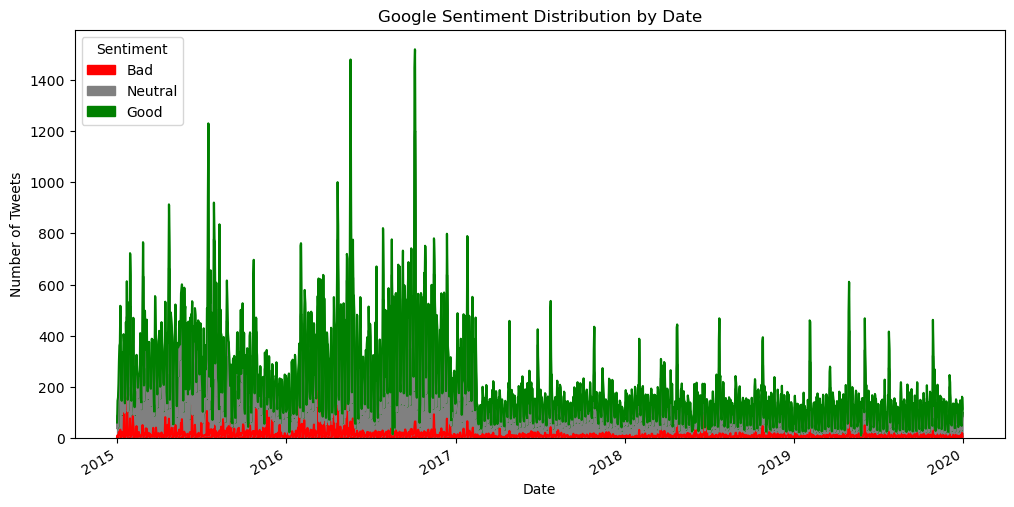

In [368]:
tw_google['date'] = pd.to_datetime(tw_google['date'])
sentiment_counts_google = tw_google.groupby(['date', 'label']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(12, 6))
colors = {'good': 'green', 'neutral': 'grey', 'bad': 'red'}
area = sentiment_counts_google.plot.area(stacked=True, ax=ax, color=[colors[c] for c in sentiment_counts_google.columns])
handles = [mpatches.Patch(color=colors[label], label=label.capitalize()) for label in sentiment_counts_google.columns]
ax.legend(handles=handles, title='Sentiment', loc="upper left")
plt.title('Google Sentiment Distribution by Date')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.show()

In [369]:
tw_google['date'] = pd.to_datetime(tw_google['date'])
daily_sentiment_google = tw_google.groupby(tw_google['date'].dt.date)['score'].mean()
daily_sentiment_df_google = pd.DataFrame({'Date': daily_sentiment_google.index, 'Average Score': daily_sentiment_google.values})
daily_sentiment_df_google.head()

,Date,Average Score
0,2015-01-01,0.111073
1,2015-01-02,0.133178
2,2015-01-03,0.357689
3,2015-01-04,0.340875
4,2015-01-05,0.205408


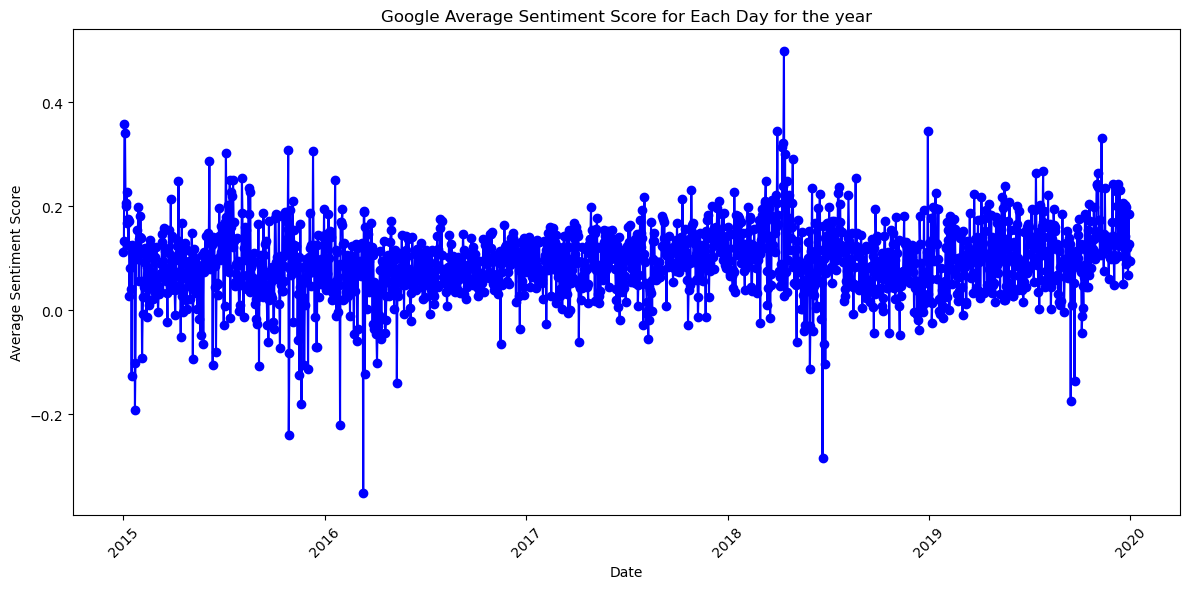

In [370]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(daily_sentiment_google.index, daily_sentiment_google, marker='o', linestyle='-', color='b')
ax.set_xlabel('Date')
ax.set_ylabel('Average Sentiment Score')
plt.title('Google Average Sentiment Score for Each Day for the year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

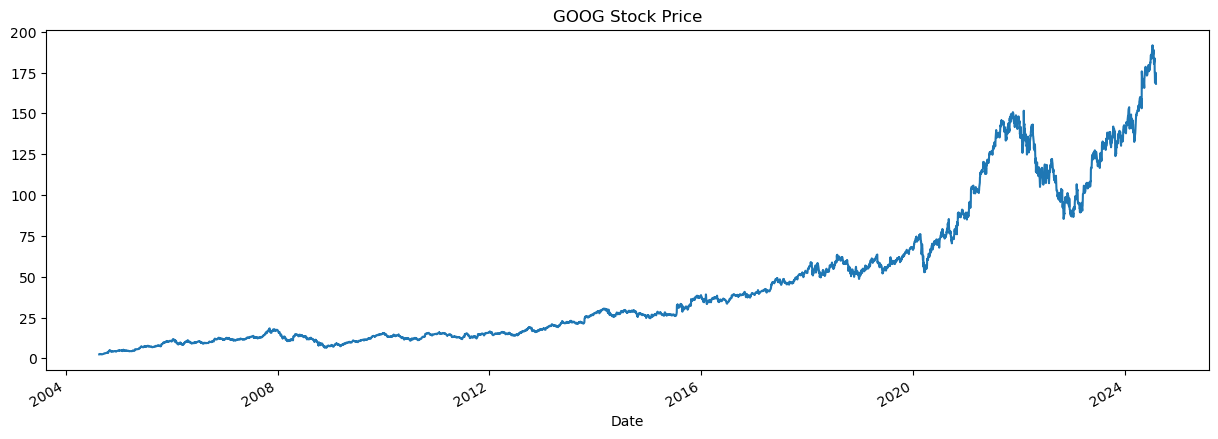

In [372]:
import yfinance as yf
goog = yf.Ticker("GOOG")
hist = goog.history(period="max")
hist["Open"].plot(figsize=(15, 5), title="GOOG Stock Price")
plt.show()

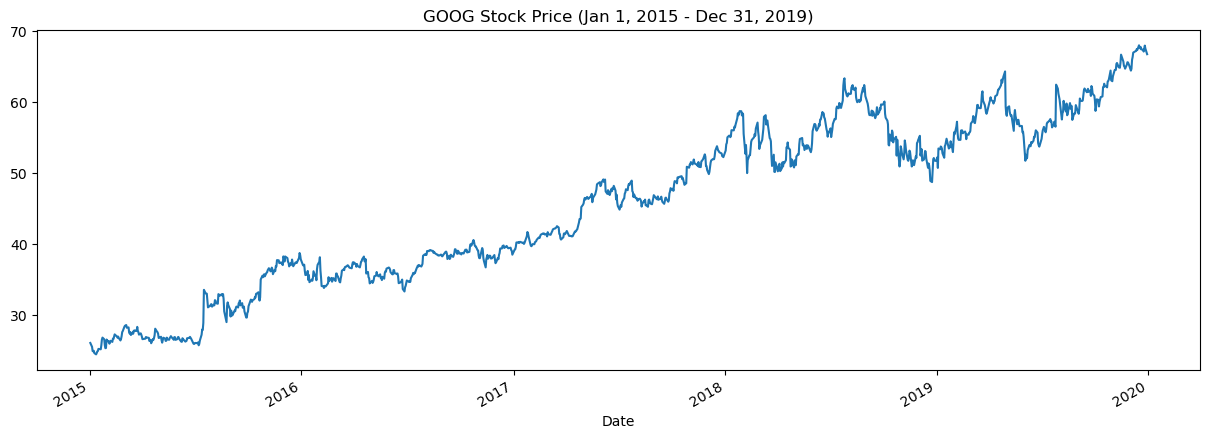

In [373]:
stock_symbol = "GOOG"
start_date = "2015-01-01"
end_date = "2019-12-31"
stock_goog = yf.Ticker(stock_symbol)
hist = stock_goog.history(period="1d", start=start_date, end=end_date)
hist["Close"].plot(figsize=(15, 5), title=f"{stock_symbol} Stock Price (Jan 1, 2015 - Dec 31, 2019)")
plt.show()

In [374]:
start_date = '2015-01-01'
end_date = '2019-12-31'
date_range_google = pd.date_range(start=start_date, end=end_date)
full_hist_google = pd.DataFrame(index=date_range_google)
full_hist_google.index = full_hist_google.index.tz_localize(hist.index.tz)
full_hist_google = full_hist_google.combine_first(hist)
full_hist_google = full_hist_google.fillna(0)
full_hist_google.head()

,Close,Dividends,High,Low,Open,Stock Splits,Volume
2015-01-01 00:00:00-05:00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2015-01-02 00:00:00-05:00,26.138908,0.0,26.460659,26.103546,26.348095,0.0,28951268.0
2015-01-03 00:00:00-05:00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2015-01-04 00:00:00-05:00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0
2015-01-05 00:00:00-05:00,25.594027,0.0,26.115002,25.553684,26.061708,0.0,41196796.0


In [35]:
tw_google.to_csv('sentimental_dataset_google.csv', index=False)

# Models

## Apple Model

In [36]:
data_apple = pd.read_csv('sentimental_dataset_apple.csv')

In [37]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

In [38]:
data_apple['body'] = data_apple['body'].apply(preprocess_text)

In [51]:
data_apple

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441509175443456,lx21 made 10008 on aapl check it out httpprof...,AAPL
1,2015-01-01,-0.8271,bad,550441672312512512,insanity of today weirdo massive selling aapl ...,AAPL
2,2015-01-01,0.0000,neutral,550443807834402816,swing trading up to 891 return in 14 days http...,AAPL
3,2015-01-01,0.0000,neutral,550443808606126081,swing trading up to 891 return in 14 days http...,AAPL
4,2015-01-01,0.0000,neutral,550443809700851716,swing trading up to 891 return in 14 days http...,AAPL
...,...,...,...,...,...,...
1207996,2018-12-31,0.8519,good,1079883982794379264,join robinhoodapp and well both get a stock li...,AAPL
1207997,2018-12-31,0.0000,neutral,1079884177770655744,comment its 2019 instagram should make an ipad...,AAPL
1207998,2018-12-31,-0.9001,bad,1079884283433574400,aapl gap data notice lower wick 1st 15min bar ...,AAPL
1207999,2018-12-31,-0.6917,bad,1079887341366530049,50 points today come start the new year out ri...,AAPL


In [202]:
X = data_apple['body']
y = data_apple['label']

In [203]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [204]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [205]:
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [206]:
y_pred = model.predict(X_test)

In [207]:
report = classification_report(y_test, y_pred)

In [208]:
print(report)

              precision    recall  f1-score   support

         bad       0.84      0.76      0.80     16888
        good       0.92      0.90      0.91     73915
     neutral       0.93      0.95      0.94    150798

    accuracy                           0.92    241601
   macro avg       0.90      0.87      0.88    241601
weighted avg       0.92      0.92      0.92    241601



In [209]:
cm = confusion_matrix(y_test, y_pred, labels=["good", "bad", "neutral"])

In [210]:
cm

array([[ 66205,    269,   7441],
       [   199,  12901,   3788],
       [  5200,   2252, 143346]])

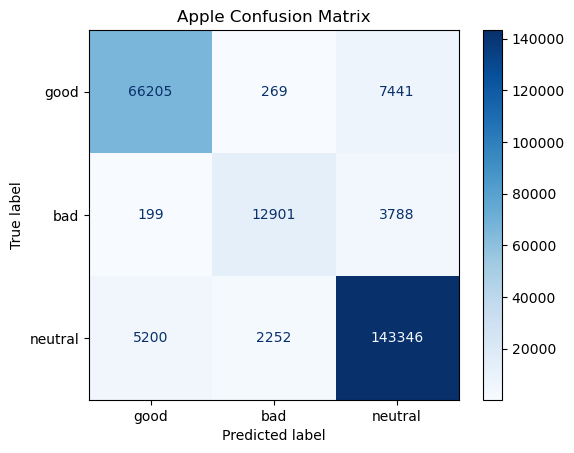

In [211]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["good", "bad", "neutral"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Apple Confusion Matrix")
plt.show()

In [62]:
def predict_sentiment(new_texts):
    new_texts = [preprocess_text(text) for text in new_texts]
    new_texts_tfidf = vectorizer.transform(new_texts)
    predictions = model.predict(new_texts_tfidf)
    return predictions

In [63]:
new_texts = ["Great news for investors! $AAPL, $TSLA, and $AMZN stocks are on the rise, hitting new highs today. Bullish trends continue as market optimism grows. 📈🚀 #StockMarket #Investing #BullMarket"]

In [64]:
predictions = predict_sentiment(new_texts)

In [65]:
print(predictions)

['good']


### Regression Model for Apple

In [213]:
data_apple['date'] = pd.to_datetime(data_apple['date'])

In [214]:
data_apple

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441509175443456,lx21 made 10008 on aapl check it out httpprof...,AAPL
1,2015-01-01,-0.8271,bad,550441672312512512,insanity of today weirdo massive selling aapl ...,AAPL
2,2015-01-01,0.0000,neutral,550443807834402816,swing trading up to 891 return in 14 days http...,AAPL
3,2015-01-01,0.0000,neutral,550443808606126081,swing trading up to 891 return in 14 days http...,AAPL
4,2015-01-01,0.0000,neutral,550443809700851716,swing trading up to 891 return in 14 days http...,AAPL
...,...,...,...,...,...,...
1207996,2018-12-31,0.8519,good,1079883982794379264,join robinhoodapp and well both get a stock li...,AAPL
1207997,2018-12-31,0.0000,neutral,1079884177770655744,comment its 2019 instagram should make an ipad...,AAPL
1207998,2018-12-31,-0.9001,bad,1079884283433574400,aapl gap data notice lower wick 1st 15min bar ...,AAPL
1207999,2018-12-31,-0.6917,bad,1079887341366530049,50 points today come start the new year out ri...,AAPL


In [215]:
data = data_apple[['date', 'score']]

In [216]:
data_apple

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441509175443456,lx21 made 10008 on aapl check it out httpprof...,AAPL
1,2015-01-01,-0.8271,bad,550441672312512512,insanity of today weirdo massive selling aapl ...,AAPL
2,2015-01-01,0.0000,neutral,550443807834402816,swing trading up to 891 return in 14 days http...,AAPL
3,2015-01-01,0.0000,neutral,550443808606126081,swing trading up to 891 return in 14 days http...,AAPL
4,2015-01-01,0.0000,neutral,550443809700851716,swing trading up to 891 return in 14 days http...,AAPL
...,...,...,...,...,...,...
1207996,2018-12-31,0.8519,good,1079883982794379264,join robinhoodapp and well both get a stock li...,AAPL
1207997,2018-12-31,0.0000,neutral,1079884177770655744,comment its 2019 instagram should make an ipad...,AAPL
1207998,2018-12-31,-0.9001,bad,1079884283433574400,aapl gap data notice lower wick 1st 15min bar ...,AAPL
1207999,2018-12-31,-0.6917,bad,1079887341366530049,50 points today come start the new year out ri...,AAPL


In [217]:
new_data = pd.DataFrame(data.groupby('date').agg({'score':'mean'}).reset_index())

In [218]:
new_data['months'] = new_data['date'].dt.month

In [219]:
new_data['years'] = new_data['date'].dt.year

In [220]:
new_data['date'] = pd.to_datetime(new_data['years'].astype(str) + '-' + new_data['months'].astype(str) + '-01', format='%Y-%m-%d')

In [221]:
new_data.drop(['months', 'years'], axis=1, inplace=True)

In [222]:
new_data

,date,score
0,2015-01-01,0.132334
1,2015-01-01,0.072022
2,2015-01-01,0.263895
3,2015-01-01,0.218598
4,2015-01-01,0.120478
...,...,...
1449,2018-12-01,0.174627
1450,2018-12-01,0.190125
1451,2018-12-01,0.228813
1452,2018-12-01,0.326615


In [223]:
new_data_monthly = pd.DataFrame(new_data.groupby('date').agg({'score':'mean'}).reset_index())

In [224]:
new_data_monthly['date_ordinal'] = new_data_monthly['date'].apply(lambda x: x.toordinal())

In [225]:
X = new_data_monthly['date_ordinal'].values.reshape(-1, 1)
y = new_data_monthly['score'].values

In [226]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [227]:
y_pred = model.predict(X)

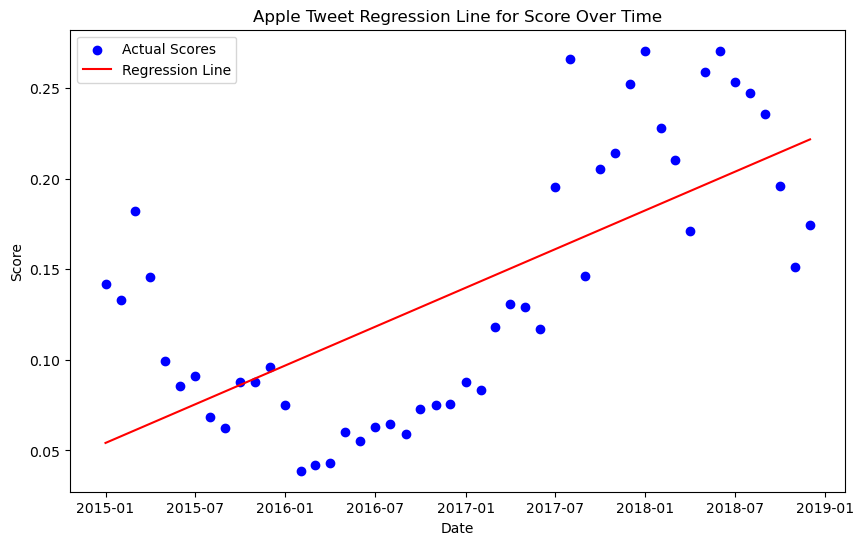

In [228]:
plt.figure(figsize=(10, 6))
plt.scatter(new_data_monthly['date'], new_data_monthly['score'], color='blue', label='Actual Scores')
plt.plot(new_data_monthly['date'], y_pred, color='red', label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Apple Tweet Regression Line for Score Over Time')
plt.legend()
plt.show()

### Apple Finance Model

In [229]:
apple_finance = pd.read_csv('datasets/AAPL.csv')

In [230]:
apple_finance['Date'] = pd.to_datetime(apple_finance['Date'])

In [231]:
apple_finance['Date_ordinal'] = apple_finance['Date'].apply(lambda x: x.toordinal())

In [232]:
apple_finance

,Date,Open,High,Low,Close,Adj Close,Volume,Date_ordinal
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400,735600
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714725,257142000,735603
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716953,263188400,735604
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049515,160423600,735605
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973562,237458000,735606
...,...,...,...,...,...,...,...,...
1505,2020-12-23,132.160004,132.429993,130.779999,130.960007,128.349152,88223700,737782
1506,2020-12-24,131.320007,133.460007,131.100006,131.970001,129.339035,54930100,737783
1507,2020-12-28,133.990005,137.339996,133.509995,136.690002,133.964935,124486200,737787
1508,2020-12-29,138.050003,138.789993,134.339996,134.869995,132.181213,121047300,737788


In [233]:
scaler = MinMaxScaler(feature_range=(0, 0.25))

In [234]:
apple_finance['Close_scaled'] = scaler.fit_transform(apple_finance[['Close']])

In [235]:
apple_finance

,Date,Open,High,Low,Close,Adj Close,Volume,Date_ordinal,Close_scaled
0,2015-01-02,27.847500,27.860001,26.837500,27.332500,24.402172,212818400,735600,0.010402
1,2015-01-05,27.072500,27.162500,26.352501,26.562500,23.714725,257142000,735603,0.008715
2,2015-01-06,26.635000,26.857500,26.157499,26.565001,23.716953,263188400,735604,0.008720
3,2015-01-07,26.799999,27.049999,26.674999,26.937500,24.049515,160423600,735605,0.009536
4,2015-01-08,27.307501,28.037500,27.174999,27.972500,24.973562,237458000,735606,0.011804
...,...,...,...,...,...,...,...,...,...
1505,2020-12-23,132.160004,132.429993,130.779999,130.960007,128.349152,88223700,737782,0.237446
1506,2020-12-24,131.320007,133.460007,131.100006,131.970001,129.339035,54930100,737783,0.239659
1507,2020-12-28,133.990005,137.339996,133.509995,136.690002,133.964935,124486200,737787,0.250000
1508,2020-12-29,138.050003,138.789993,134.339996,134.869995,132.181213,121047300,737788,0.246012


In [236]:
apple_new = pd.DataFrame(apple_finance.groupby('Date').agg({'Close_scaled':'mean'}).reset_index())

In [237]:
apple_new['Months'] = apple_new['Date'].dt.month
apple_new['Years'] = apple_new['Date'].dt.year

In [238]:
apple_new['Date'] = pd.to_datetime(apple_new['Years'].astype(str) + '-' + apple_new['Months'].astype(str), format='%Y-%m')

In [239]:
apple_new.drop(['Months', 'Years'], axis=1, inplace=True)

In [240]:
apple_new_monthly = pd.DataFrame(apple_new.groupby('Date').agg({'Close_scaled':'mean'}).reset_index())

In [241]:
apple_new_monthly['Date_ordinal'] = apple_new_monthly['Date'].map(pd.Timestamp.toordinal)

In [242]:
X = apple_new_monthly['Date_ordinal'].values.reshape(-1, 1)
y = apple_new_monthly['Close_scaled'].values

In [243]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [244]:
y_pred1 = model.predict(X)

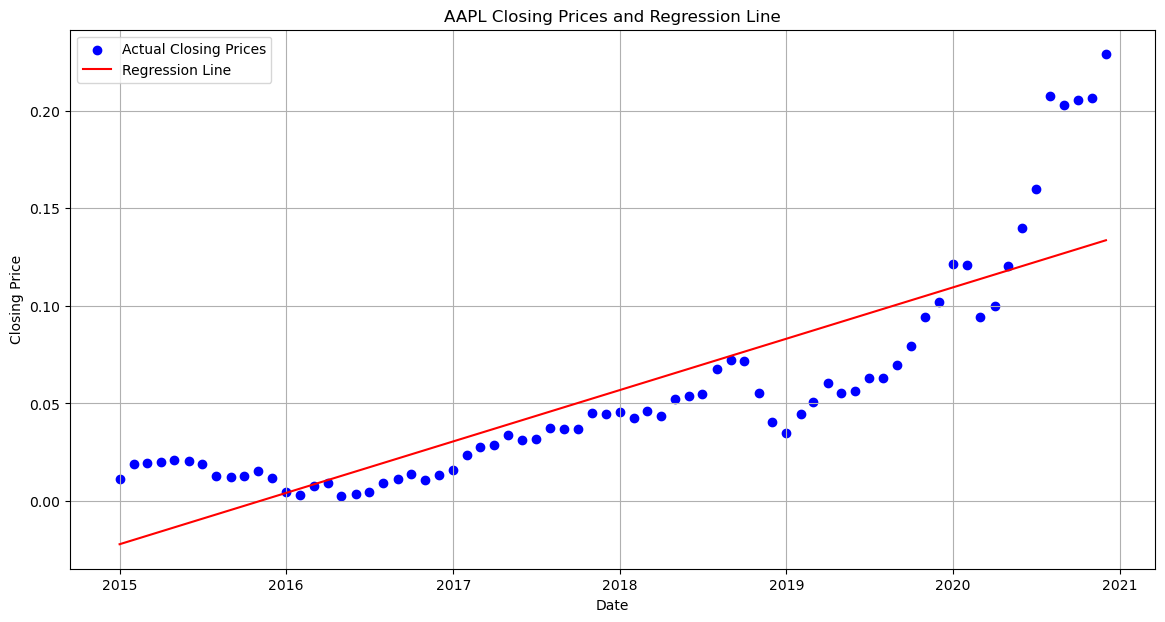

In [245]:
plt.figure(figsize=(14, 7))
plt.scatter(apple_new_monthly['Date'], y, color='blue', label='Actual Closing Prices')
plt.plot(apple_new_monthly['Date'], y_pred1, color='red', label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AAPL Closing Prices and Regression Line')
plt.legend()
plt.grid(True)
plt.show()

### Compairing Apple tweets with Apple finance data Regression lines

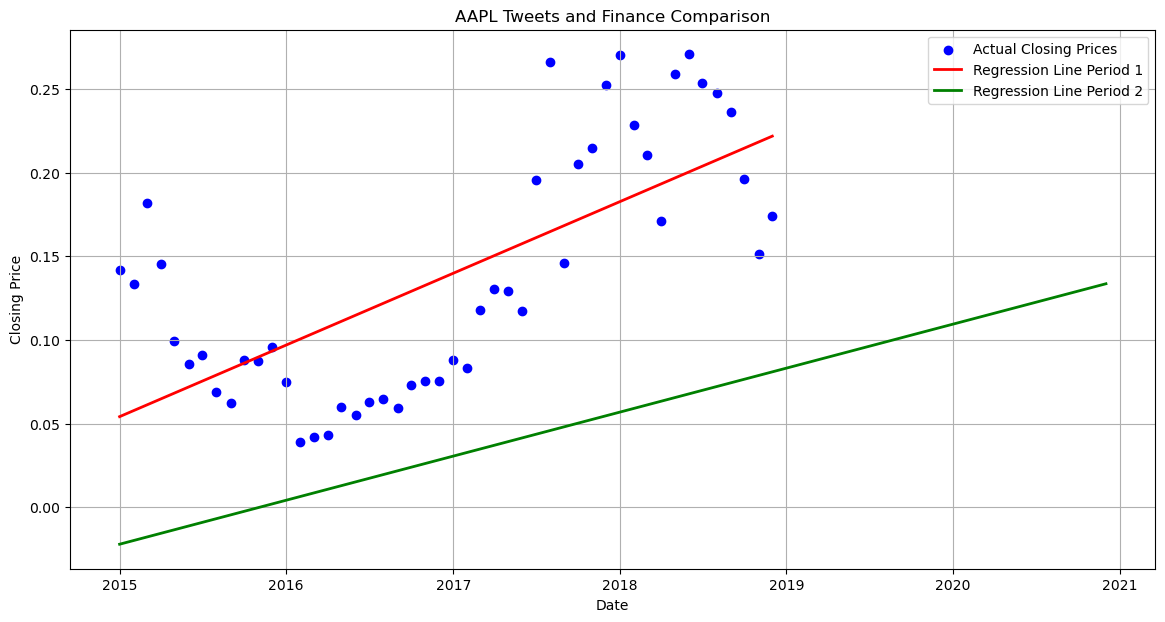

In [246]:
plt.figure(figsize=(14, 7))
plt.scatter(new_data_monthly['date'], new_data_monthly['score'], color='blue', label='Actual Closing Prices')
plt.plot(new_data_monthly['date'], y_pred, color='red', linewidth=2, label='Regression Line Period 1')
plt.plot(apple_new_monthly['Date'], y_pred1, color='green', linewidth=2, label='Regression Line Period 2')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AAPL Tweets and Finance Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Amazon Model

In [267]:
data_amazon = pd.read_csv('sentimental_dataset_amazon.csv')

In [268]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

In [269]:
data_amazon['body'] = data_amazon['body'].apply(preprocess_text)

In [270]:
data_amazon

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441732014223360,sp100 stocks performance hd low sbux tgt dvn i...,AMZN
1,2015-01-01,0.2023,neutral,550447850857828352,top 10 searched stocks of 2014 aapl fb baba ts...,AMZN
2,2015-01-01,0.0000,neutral,550453172096217088,rt seekingalpha a look at blackberrys deals an...,AMZN
3,2015-01-01,-0.7506,bad,550453624258965505,jeff bezos lost 74 billion in amazons worst ye...,AMZN
4,2015-01-01,-0.7506,bad,550453897714995200,jeff bezos lost 74 billion in amazon worst yea...,AMZN
...,...,...,...,...,...,...
718710,2019-12-31,0.2023,neutral,1212154334600818689,yahoo finance video december 31 2019 amzn zng...,AMZN
718711,2019-12-31,0.8176,good,1212155226377117697,ryzenn aapl has to have a lights out er to kee...,AMZN
718712,2019-12-31,0.6908,good,1212156775178416128,is there a public database or website where i ...,AMZN
718713,2019-12-31,0.0000,neutral,1212157343351238656,fb amzn googl nflx fang 2019,AMZN


In [271]:
X = data_amazon['body']
y = data_amazon['label']

In [272]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [273]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [274]:
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [275]:
y_pred = model.predict(X_test)

In [276]:
report = classification_report(y_test, y_pred)

In [277]:
print(report)

              precision    recall  f1-score   support

         bad       0.83      0.71      0.76     11345
        good       0.92      0.88      0.90     48736
     neutral       0.90      0.94      0.92     83662

    accuracy                           0.90    143743
   macro avg       0.88      0.84      0.86    143743
weighted avg       0.90      0.90      0.90    143743



In [278]:
cm = confusion_matrix(y_test, y_pred, labels=["good", "bad", "neutral"])

In [279]:
cm

array([[43078,   198,  5460],
       [  185,  8004,  3156],
       [ 3812,  1473, 78377]])

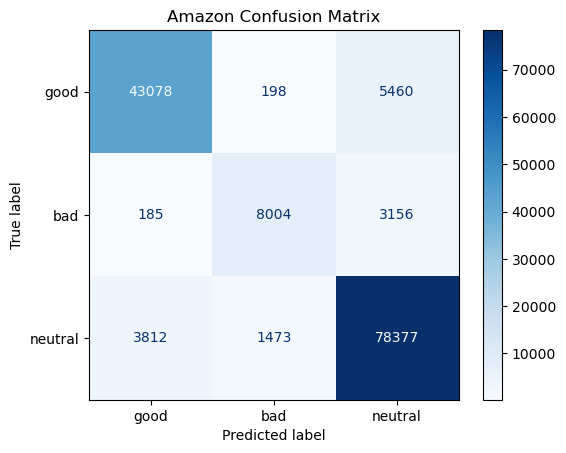

In [280]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["good", "bad", "neutral"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Amazon Confusion Matrix")
plt.show()

In [281]:
def predict_sentiment(new_texts):
    new_texts = [preprocess_text(text) for text in new_texts]
    new_texts_tfidf = vectorizer.transform(new_texts)
    predictions = model.predict(new_texts_tfidf)
    return predictions

In [282]:
new_texts = ["Great news for investors! $AAPL, $TSLA, and $AMZN stocks are on the rise, hitting new highs today. Bullish trends continue as market optimism grows. 📈🚀 #StockMarket #Investing #BullMarket"]

In [283]:
predictions = predict_sentiment(new_texts)

In [284]:
print(predictions)

['good']


### Regression Model for Amazon

In [285]:
data_amazon['date'] = pd.to_datetime(data_amazon['date'])

In [286]:
data_amazon

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.0000,neutral,550441732014223360,sp100 stocks performance hd low sbux tgt dvn i...,AMZN
1,2015-01-01,0.2023,neutral,550447850857828352,top 10 searched stocks of 2014 aapl fb baba ts...,AMZN
2,2015-01-01,0.0000,neutral,550453172096217088,rt seekingalpha a look at blackberrys deals an...,AMZN
3,2015-01-01,-0.7506,bad,550453624258965505,jeff bezos lost 74 billion in amazons worst ye...,AMZN
4,2015-01-01,-0.7506,bad,550453897714995200,jeff bezos lost 74 billion in amazon worst yea...,AMZN
...,...,...,...,...,...,...
718710,2019-12-31,0.2023,neutral,1212154334600818689,yahoo finance video december 31 2019 amzn zng...,AMZN
718711,2019-12-31,0.8176,good,1212155226377117697,ryzenn aapl has to have a lights out er to kee...,AMZN
718712,2019-12-31,0.6908,good,1212156775178416128,is there a public database or website where i ...,AMZN
718713,2019-12-31,0.0000,neutral,1212157343351238656,fb amzn googl nflx fang 2019,AMZN


In [287]:
data = data_amazon[['date', 'score']]

In [288]:
data

,date,score
0,2015-01-01,0.0000
1,2015-01-01,0.2023
2,2015-01-01,0.0000
3,2015-01-01,-0.7506
4,2015-01-01,-0.7506
...,...,...
718710,2019-12-31,0.2023
718711,2019-12-31,0.8176
718712,2019-12-31,0.6908
718713,2019-12-31,0.0000


In [289]:
new_data = pd.DataFrame(data.groupby('date').agg({'score':'mean'}).reset_index())

In [290]:
new_data['months'] = new_data['date'].dt.month

In [291]:
new_data['years'] = new_data['date'].dt.year

In [292]:
new_data['date'] = pd.to_datetime(new_data['years'].astype(str) + '-' + new_data['months'].astype(str) + '-01', format='%Y-%m-%d')

In [293]:
new_data.drop(['months', 'years'], axis=1, inplace=True)

In [294]:
new_data_monthly = pd.DataFrame(new_data.groupby('date').agg({'score':'mean'}).reset_index())

In [295]:
new_data_monthly['date_ordinal'] = new_data_monthly['date'].apply(lambda x: x.toordinal())

In [296]:
X = new_data_monthly['date_ordinal'].values.reshape(-1, 1)
y = new_data_monthly['score'].values

In [297]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [298]:
y_pred = model.predict(X)

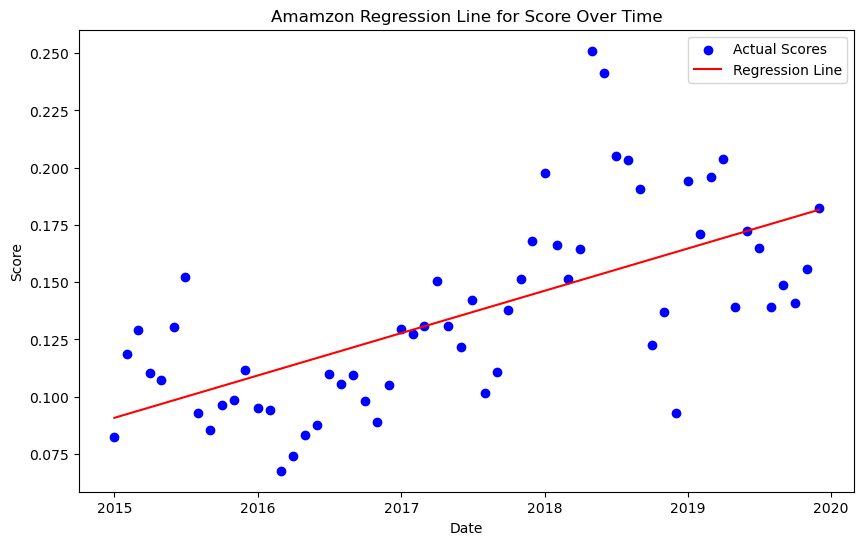

In [299]:
plt.figure(figsize=(10, 6))
plt.scatter(new_data_monthly['date'], new_data_monthly['score'], color='blue', label='Actual Scores')
plt.plot(new_data_monthly['date'], y_pred, color='red', label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Amamzon Regression Line for Score Over Time')
plt.legend()
plt.show()

### Amazon Finance Model

In [300]:
amazon_finance = pd.read_csv('datasets/AMZN.csv')

In [301]:
amazon_finance['Date'] = pd.to_datetime(amazon_finance['Date'])

In [302]:
amazon_finance['Date_ordinal'] = amazon_finance['Date'].apply(lambda x: x.toordinal())

In [303]:
amazon_finance

,Date,Open,High,Low,Close,Adj Close,Volume,Date_ordinal
0,2015-01-02,15.629000,15.737500,15.348000,15.426000,15.426000,55664000,735600
1,2015-01-05,15.350500,15.419000,15.042500,15.109500,15.109500,55484000,735603
2,2015-01-06,15.112000,15.150000,14.619000,14.764500,14.764500,70380000,735604
3,2015-01-07,14.875000,15.064000,14.766500,14.921000,14.921000,52806000,735605
4,2015-01-08,15.016000,15.157000,14.805500,15.023000,15.023000,61768000,735606
...,...,...,...,...,...,...,...,...
1505,2020-12-23,160.250000,160.506500,159.208496,159.263504,159.263504,41876000,737782
1506,2020-12-24,159.695007,160.100006,158.449997,158.634506,158.634506,29038000,737783
1507,2020-12-28,159.699997,165.199997,158.634506,164.197998,164.197998,113736000,737787
1508,2020-12-29,165.496994,167.532501,164.061005,166.100006,166.100006,97458000,737788


In [304]:
scaler = MinMaxScaler(feature_range=(0, 0.25))

In [305]:
amazon_finance['Close_scaled'] = scaler.fit_transform(amazon_finance[['Close']])

In [306]:
amazon_new = pd.DataFrame(amazon_finance.groupby('Date').agg({'Close_scaled':'mean'}).reset_index())

In [307]:
amazon_new['Months'] = amazon_new['Date'].dt.month
amazon_new['Years'] = amazon_new['Date'].dt.year

In [308]:
amazon_new['Date'] = pd.to_datetime(amazon_new['Years'].astype(str) + '-' + amazon_new['Months'].astype(str), format='%Y-%m')

In [309]:
amazon_new.drop(['Months', 'Years'], axis=1, inplace=True)

In [310]:
amazon_new_monthly = pd.DataFrame(amazon_new.groupby('Date').agg({'Close_scaled':'mean'}).reset_index())

In [311]:
amazon_new_monthly['Date_ordinal'] = amazon_new_monthly['Date'].map(pd.Timestamp.toordinal)

In [312]:
X = amazon_new_monthly['Date_ordinal'].values.reshape(-1, 1)
y = amazon_new_monthly['Close_scaled'].values

In [313]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [314]:
y_pred1 = model.predict(X)

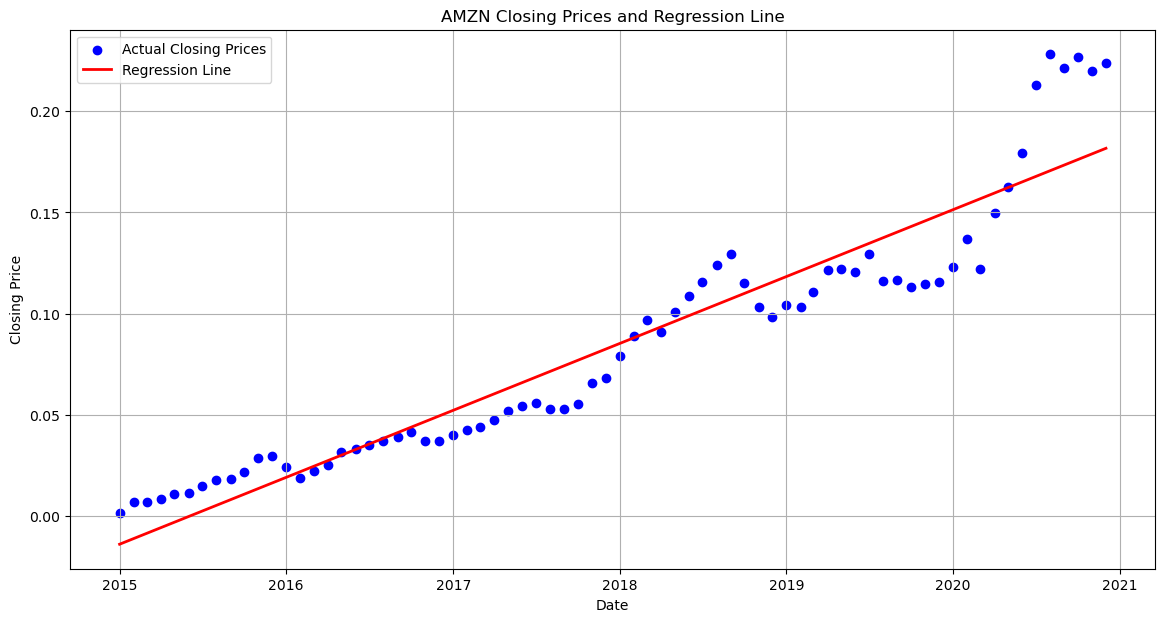

In [315]:
plt.figure(figsize=(14, 7))
plt.scatter(amazon_new_monthly['Date'], y, color='blue', label='Actual Closing Prices')
plt.plot(amazon_new_monthly['Date'], y_pred1, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Closing Prices and Regression Line')
plt.legend()
plt.grid(True)
plt.show()

### Compairing Tesla tweets with Tesla finance data Regression lines

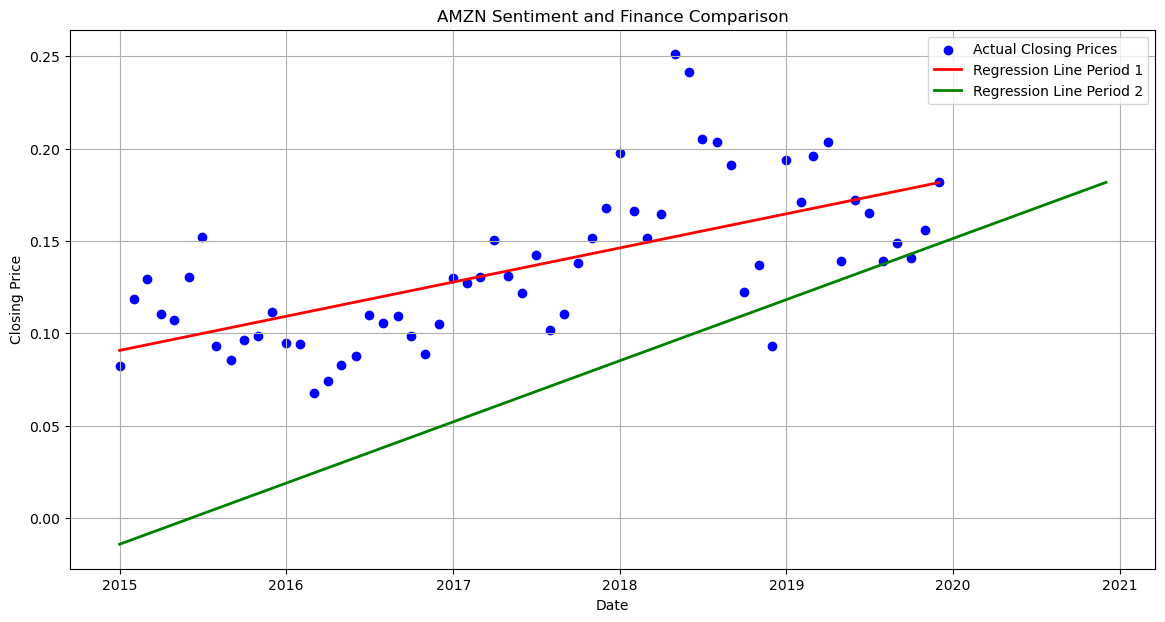

In [316]:
plt.figure(figsize=(14, 7))
plt.scatter(new_data_monthly['date'], new_data_monthly['score'], color='blue', label='Actual Closing Prices')
plt.plot(new_data_monthly['date'], y_pred, color='red', linewidth=2, label='Regression Line Period 1')
plt.plot(amazon_new_monthly['Date'], y_pred1, color='green', linewidth=2, label='Regression Line Period 2')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('AMZN Sentiment and Finance Comparison')
plt.legend()
plt.grid(True)
plt.show()

## Google Model

In [317]:
data_google = pd.read_csv('sentimental_dataset_google.csv')

In [318]:
def preprocess_text(text):
    text = text.lower()
    text = ''.join(e for e in text if e.isalnum() or e.isspace())
    return text

In [319]:
data_google['body'] = data_google['body'].apply(preprocess_text)

In [320]:
data_google

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.2023,neutral,550447850857828352,top 10 searched stocks of 2014 aapl fb baba ts...,GOOG
1,2015-01-01,-0.6486,neutral,550449439631233026,google c chinese paper blames google over gma...,GOOG
2,2015-01-01,0.6249,good,550453087731982336,httpiphoneappleinsidercomarticles141230editori...,GOOG
3,2015-01-01,0.5423,good,550461555423584257,prediction twtr grpn yelp are acquired as big ...,GOOG
4,2015-01-01,-0.4767,neutral,550463776437174272,goog is roughly fairly valued not a buy or sell,GOOG
...,...,...,...,...,...,...
392564,2019-12-31,0.0000,neutral,1212145509579837440,goog patent 10524006 automatic transition of c...,GOOG
392565,2019-12-31,0.8714,good,1212146656335949824,im banking on this and that google will still ...,GOOG
392566,2019-12-31,0.7184,good,1212154530848227328,screen through high rated articles for us tech...,GOOG
392567,2019-12-31,0.3818,good,1212154645981941760,bold moves google apple facebook and other tec...,GOOG


In [321]:
X = data_google['body']
y = data_google['label']

In [322]:
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

In [323]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [324]:
model = LogisticRegression()
model.fit(X_train, y_train)

/Users/hassanazhar/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [325]:
y_pred = model.predict(X_test)

In [326]:
report = classification_report(y_test, y_pred)

In [327]:
print(report)

              precision    recall  f1-score   support

         bad       0.86      0.73      0.79      4739
        good       0.92      0.88      0.90     20754
     neutral       0.93      0.96      0.95     53021

    accuracy                           0.93     78514
   macro avg       0.90      0.86      0.88     78514
weighted avg       0.93      0.93      0.93     78514



In [328]:
cm = confusion_matrix(y_test, y_pred, labels=["good", "bad", "neutral"])

In [329]:
cm

array([[18248,    60,  2446],
       [   45,  3461,  1233],
       [ 1469,   516, 51036]])

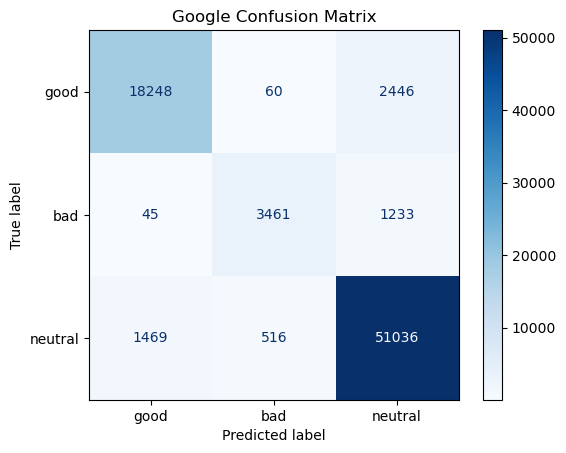

In [330]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["good", "bad", "neutral"])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Google Confusion Matrix")
plt.show()

In [331]:
def predict_sentiment(new_texts):
    new_texts = [preprocess_text(text) for text in new_texts]
    new_texts_tfidf = vectorizer.transform(new_texts)
    predictions = model.predict(new_texts_tfidf)
    return predictions

In [332]:
new_texts = ["Great news for investors! $AAPL, $TSLA, and $AMZN stocks are on the rise, hitting new highs today. Bullish trends continue as market optimism grows. 📈🚀 #StockMarket #Investing #BullMarket"]

In [333]:
predictions = predict_sentiment(new_texts)

In [334]:
print(predictions)

['good']


### Regression Model for Google

In [335]:
data_google['date'] = pd.to_datetime(data_google['date'])

In [336]:
data_google

,date,score,label,tweet_id,body,ticker_symbol
0,2015-01-01,0.2023,neutral,550447850857828352,top 10 searched stocks of 2014 aapl fb baba ts...,GOOG
1,2015-01-01,-0.6486,neutral,550449439631233026,google c chinese paper blames google over gma...,GOOG
2,2015-01-01,0.6249,good,550453087731982336,httpiphoneappleinsidercomarticles141230editori...,GOOG
3,2015-01-01,0.5423,good,550461555423584257,prediction twtr grpn yelp are acquired as big ...,GOOG
4,2015-01-01,-0.4767,neutral,550463776437174272,goog is roughly fairly valued not a buy or sell,GOOG
...,...,...,...,...,...,...
392564,2019-12-31,0.0000,neutral,1212145509579837440,goog patent 10524006 automatic transition of c...,GOOG
392565,2019-12-31,0.8714,good,1212146656335949824,im banking on this and that google will still ...,GOOG
392566,2019-12-31,0.7184,good,1212154530848227328,screen through high rated articles for us tech...,GOOG
392567,2019-12-31,0.3818,good,1212154645981941760,bold moves google apple facebook and other tec...,GOOG


In [337]:
data = data_google[['date', 'score']]

In [338]:
data

,date,score
0,2015-01-01,0.2023
1,2015-01-01,-0.6486
2,2015-01-01,0.6249
3,2015-01-01,0.5423
4,2015-01-01,-0.4767
...,...,...
392564,2019-12-31,0.0000
392565,2019-12-31,0.8714
392566,2019-12-31,0.7184
392567,2019-12-31,0.3818


In [339]:
new_data = pd.DataFrame(data.groupby('date').agg({'score':'mean'}).reset_index())

In [340]:
new_data['months'] = new_data['date'].dt.month

In [341]:
new_data['years'] = new_data['date'].dt.year

In [342]:
new_data['date'] = pd.to_datetime(new_data['years'].astype(str) + '-' + new_data['months'].astype(str) + '-01', format='%Y-%m-%d')

In [343]:
new_data.drop(['months', 'years'], axis=1, inplace=True)

In [344]:
new_data_monthly = pd.DataFrame(new_data.groupby('date').agg({'score':'mean'}).reset_index())

In [345]:
new_data_monthly['date_ordinal'] = new_data_monthly['date'].apply(lambda x: x.toordinal())

In [346]:
X = new_data_monthly['date_ordinal'].values.reshape(-1, 1)
y = new_data_monthly['score'].values

In [347]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [348]:
y_pred = model.predict(X)

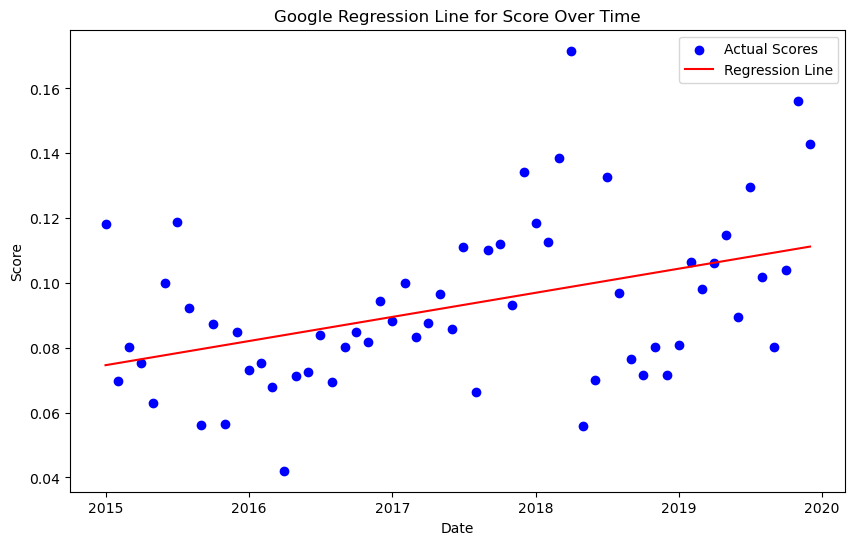

In [349]:
plt.figure(figsize=(10, 6))
plt.scatter(new_data_monthly['date'], new_data_monthly['score'], color='blue', label='Actual Scores')
plt.plot(new_data_monthly['date'], y_pred, color='red', label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Score')
plt.title('Google Regression Line for Score Over Time')
plt.legend()
plt.show()

### Google Finance Model

In [350]:
google_finance = pd.read_csv('datasets/GOOG.csv')

In [351]:
google_finance['Date'] = pd.to_datetime(google_finance['Date'])

In [352]:
google_finance['Date_ordinal'] = google_finance['Date'].apply(lambda x: x.toordinal())

In [353]:
google_finance

,Date,Open,High,Low,Close,Adj Close,Volume,Date_ordinal
0,2015-01-02,26.378078,26.490770,26.133251,26.168653,26.138908,28951268,735600
1,2015-01-05,26.091366,26.144720,25.582764,25.623152,25.594027,41196796,735603
2,2015-01-06,25.679497,25.738087,24.983908,25.029282,25.000832,57998800,735604
3,2015-01-07,25.280592,25.292759,24.914099,24.986401,24.958000,41301082,735605
4,2015-01-08,24.831326,25.105074,24.482782,25.065184,25.036694,67071641,735606
...,...,...,...,...,...,...,...,...
1505,2020-12-23,86.405502,87.399498,86.251999,86.619003,86.520546,20676000,737782
1506,2020-12-24,86.750000,87.300003,86.455498,86.942497,86.843674,6936000,737783
1507,2020-12-28,87.581749,89.536400,87.316750,88.804497,88.703560,27860000,737787
1508,2020-12-29,89.389503,89.622002,87.804497,87.935997,87.836044,25988000,737788


In [354]:
scaler = MinMaxScaler(feature_range=(0, 0.25))

In [355]:
google_finance['Close_scaled'] = scaler.fit_transform(google_finance[['Close']])

In [356]:
google_new = pd.DataFrame(google_finance.groupby('Date').agg({'Close_scaled':'mean'}).reset_index())

In [357]:
google_new['Months'] = google_new['Date'].dt.month
google_new['Years'] = google_new['Date'].dt.year

In [358]:
google_new['Date'] = pd.to_datetime(google_new['Years'].astype(str) + '-' + google_new['Months'].astype(str), format='%Y-%m')

In [359]:
google_new.drop(['Months', 'Years'], axis=1, inplace=True)

In [360]:
google_new_monthly = pd.DataFrame(google_new.groupby('Date').agg({'Close_scaled':'mean'}).reset_index())

In [361]:
google_new_monthly['Date_ordinal'] = google_new_monthly['Date'].map(pd.Timestamp.toordinal)

In [362]:
X = google_new_monthly['Date_ordinal'].values.reshape(-1, 1)
y = google_new_monthly['Close_scaled'].values

In [363]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [364]:
y_pred1 = model.predict(X)

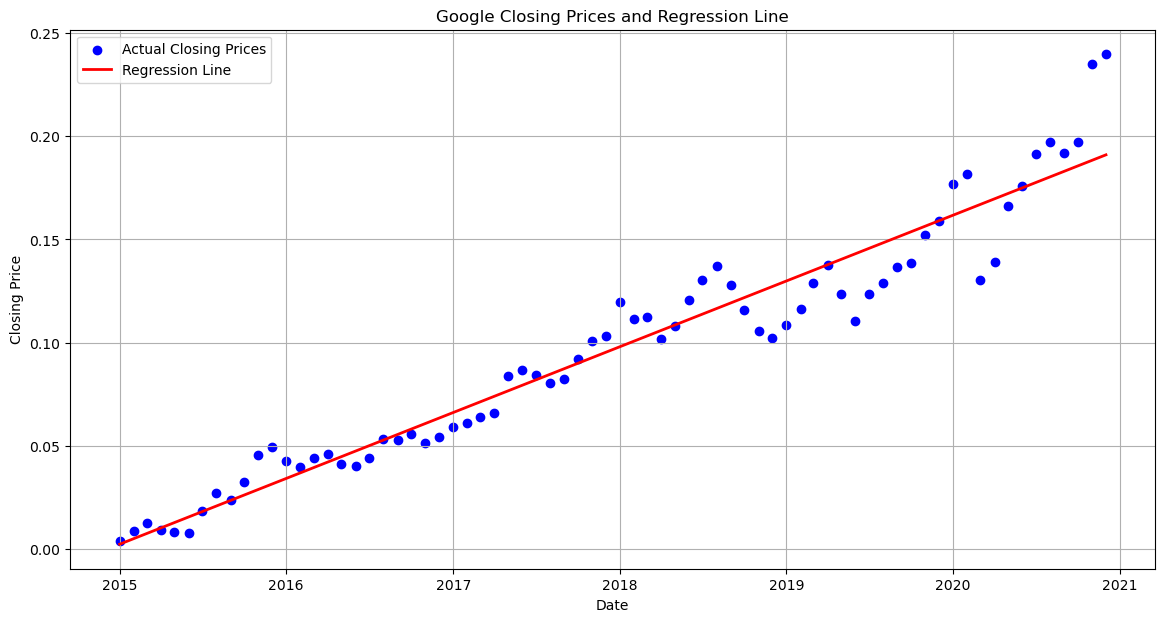

In [365]:
plt.figure(figsize=(14, 7))
plt.scatter(google_new_monthly['Date'], y, color='blue', label='Actual Closing Prices')
plt.plot(google_new_monthly['Date'], y_pred1, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Google Closing Prices and Regression Line')
plt.legend()
plt.grid(True)
plt.show()

### Compairing Google tweets with Google finance data Regression lines

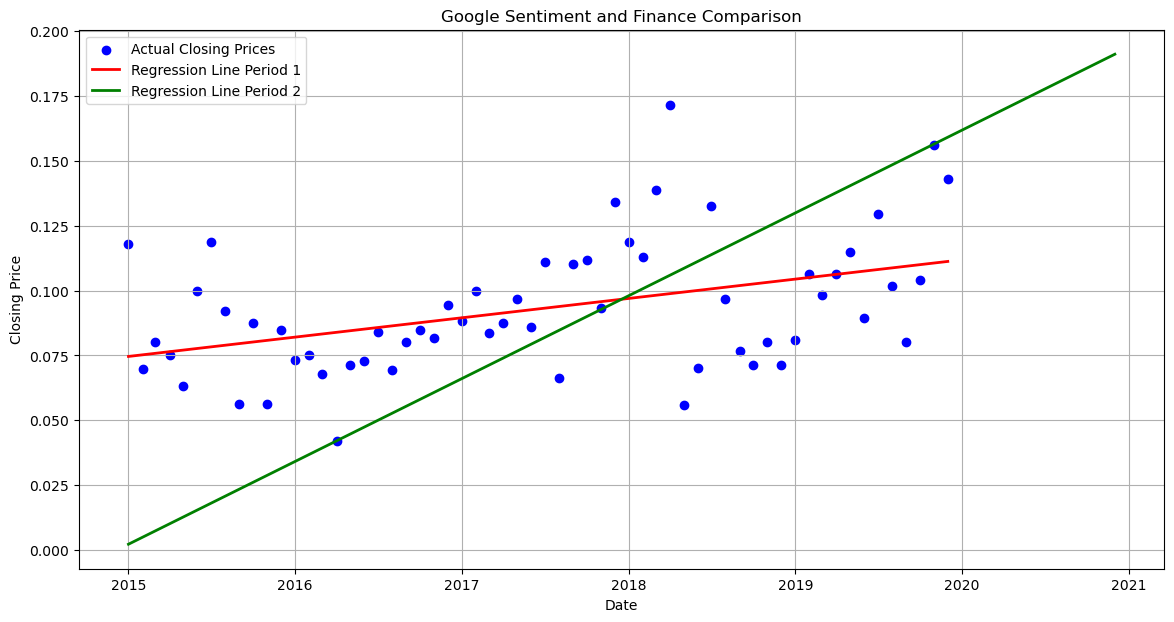

In [366]:
plt.figure(figsize=(14, 7))
plt.scatter(new_data_monthly['date'], new_data_monthly['score'], color='blue', label='Actual Closing Prices')
plt.plot(new_data_monthly['date'], y_pred, color='red', linewidth=2, label='Regression Line Period 1')
plt.plot(google_new_monthly['Date'], y_pred1, color='green', linewidth=2, label='Regression Line Period 2')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Google Sentiment and Finance Comparison')
plt.legend()
plt.grid(True)
plt.show()